# Team members
Name: Camilo Martı́nez   
Matrikelnummer: 7057573     
email: cama00005@stud.uni-saarland.de   

Name: Honglu Ma     
Matrikelnummer: 7055053     
email: homa00001@stud.uni-saarland.de   

# Exercise 8.4 (3.5 points)

The goal of this notebook is to explore the effect of various regularization strategies on the MNIST dataset.

**Implement all of your code in the assignment8.py file.
Submit the notebook with output and the python script.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.transforms import transforms, v2
from torchvision.datasets import MNIST
from torch.utils.data import Subset

from assignment8 import training_loop

In [2]:
def reduce_dataset(dataset, rng, num_samples=100) -> torch.Tensor:
    """
    Reduces the MNIST dataset to have only num_samples for each class.
    Returns the indices of all datapoints that should be kept
    """
    reduced_indices = []
    for target in range(10):
        mask = dataset.targets == target
        indices = np.nonzero(mask).flatten()
        random_subset = rng.choice(indices, size=num_samples, replace=False)
        reduced_indices.extend(random_subset)

    return reduced_indices

## 8.4.1 Model implementation (0.5 pts)

Complete the `FFNN` class, by implementing a simple feed-forward neural network with one hidden layer of size $N$ before predicting class *logits*.
The network should use ReLU activation functions and Batch Normalization.

## 8.4.2 Training & Evaluation (1 pt)
In this task we will implement training and validation for one epoch. Complete the `train`and `validate` functions by training the model on all batches in the dataloader and calculating the cross entropy loss and the accuracy (percentage of correct classes) of the model.
The functions should return the average loss and accuracy.
Make sure to put the model into the correct mode before training/evaluating.

## Data loading & Examples

In [3]:
# DO NOT CHANGE THESE CELLS
rng = np.random.default_rng(0)

normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

normalized_mnist = MNIST(root="./data", download=True, train=True, transform=normalize_transform)
tiny_mnist_indices = reduce_dataset(normalized_mnist, rng=rng, num_samples=100)
standard_train_set = Subset(normalized_mnist, tiny_mnist_indices)
test_set = MNIST(root="./data", download=True, train=False, transform=normalize_transform)

In [4]:
def plot_images(dataset):
    fig, axes = plt.subplots(10, 10)
    fig.set_size_inches(10, 6)
    
    for target in range(10):
        target_subset = dataset.data[dataset.targets == target]
        indices = np.random.choice(np.arange(len(target_subset)), 10)
        example_images = target_subset.data[indices, :, :]
        for i, image in enumerate(example_images):
            axes[target, i].imshow(image)
            axes[target, i].set_axis_off()

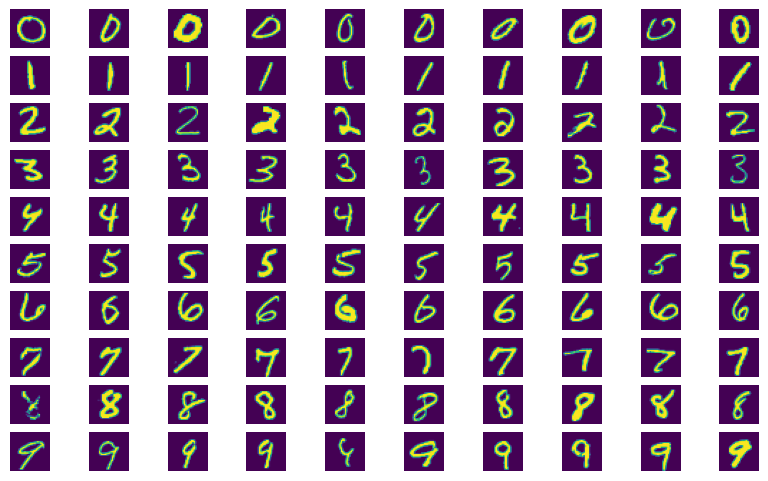

In [5]:
plot_images(test_set)

## 8.4.3 Training (1.5 pts)

Implement the `training_loop` function by integrating the `FFNN` model, developed in task 1, and the `train` and `validate` functions
from task 2.
Use SGD as the optimizer with optional weight decay.
Employ early stopping: if `early_stopping_patience` is greater than 0, terminate the training when there's no improvement on the validation set for a duration exceeding `early_stopping_patience` epochs.
It's crucial to save model parameters ('checkpoints') upon achieving better validation set performance. In the case of early stopping, revert to the parameters from the last checkpoint. Note: For parameter storage, ensure to use deepcopy since PyTorch's default behavior is to return a reference to the weights, not a copy (refer to [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html)).

Upon completion of training, graphically represent the loss and accuracy trends for both training and test datasets.

The function should return the weights of the best checkpoint and the validation loss at that point.

In [6]:
EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.01

Early stopped at 26


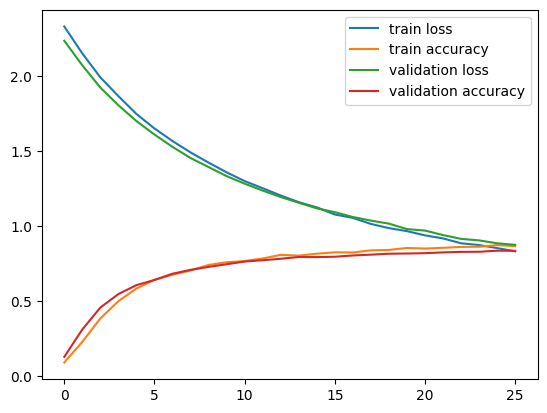

Best Accuracy: 0.8359


In [7]:
_ = training_loop(
    standard_train_set, test_set, 
    epochs=EPOCHS, 
    batch_size=32,
    learning_rate=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    early_stopping_patience=1
)

## 8.4.4 Data Augmentation (0.5 pts)
In the previous tasks we have explored the effects of weight decay and early stopping on a tiny subset of MNIST. 
In this task we will explore if data augmentation can help improve the accuracy of our small dataset. You are encouraged to play
around with the effects of various transformations on the result.

Use transformations from PyTorch's `torchvision` [package](https://pytorch.org/vision/stable/transforms.html) to augment the dataset. You are also allowed to play around with the other hyperparameters.

In [8]:
augment_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # in the lecture, it is mentioned that we should be careful with flip (RandomHorizontalFlip)
    # because 6 and 9 mirror each other
    transforms.RandomRotation(5)
])

In [9]:
# DO NOT CHANGE THESE CELLS
augmented_mnist = MNIST(root="./data", download=True, train=True, transform=augment_transform)
augmented_train_set = Subset(augmented_mnist, tiny_mnist_indices)
test_set = MNIST(root="./data", download=True, train=False, transform=normalize_transform)

Early stopped at 51


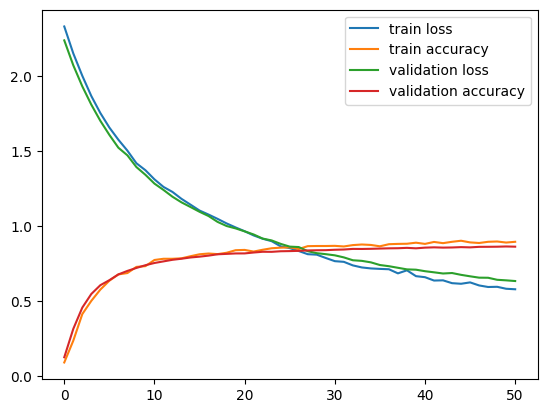

Best Accuracy: 0.8649


In [10]:
_ = training_loop(
    augmented_train_set, test_set, 
    epochs=EPOCHS, 
    batch_size=32,   # Larger dataset
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, 
    early_stopping_patience=1
)